In [7]:
import audiomentations as A
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import os
from os import path
import soundfile as sf
import librosa.display
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler


In [8]:
AUDIO_FILE_TYPES = [
    "cough-heavy",
    "cough-shallow", 
    "breathing-shallow", 
    "breathing-deep", 
    "counting-fast", 
    "counting-normal", 
    "vowel-a", 
    "vowel-e", 
    "vowel-o"
]
DATA_FILE =  "train_data.csv"
AUDIO_DIR = f"./Extracted_data"
AUGMENTED_AUDIO_DIR = f"{AUDIO_DIR}/Augmented_Audio"
TRANSFORMER = A.Compose([
  A.TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
  A.PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
  A.Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
  A.Gain(min_gain_in_db=-10, max_gain_in_db=10, p=0.5),
  A.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)
])


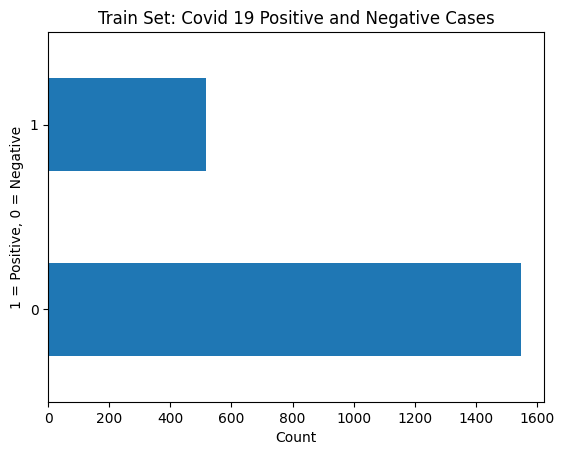

In [9]:
df = pd.read_csv(DATA_FILE)

# Get the is_positive column as a series
is_positive = df['is_positive']

# Count the number of True and False values
count = is_positive.value_counts()

# Plot the counts as a horizontal bar chart
count.plot(kind='barh')
plt.title('Train Set: Covid 19 Positive and Negative Cases')
plt.xlabel('Count')
plt.ylabel('1 = Positive, 0 = Negative')
plt.show()


In [10]:
positive_covid_data = df.loc[df["is_positive"] == 1]
positive_covid_data

,date,id,smoker,asthma,cough,cold,diabetes,hypertension,ischemic_heart_disease,breathing_difficulties,...,vaccination_dose_one dose,gender_female,gender_male,gender_other,age_group_0-20,age_group_20-40,age_group_40-60,age_group_60-80,age_group_80-100,is_positive
3,20210630,ymX9t6DWDHZTs28MODDSxDaOj4n2,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
4,20220116,2Tg0DiYjSrd86E4LBMa4OCQ4UgT2,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
11,20210630,reAwzcyQUkglluwsQnjzUymZ3f02,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
14,20220224,e7JBCb0T95RkRfQCew31KafL19w1,1,0,0,0,1,1,0,1,...,0,0,1,0,0,0,1,0,0,1
28,20220116,9YfQ4fzK7VhEKsDvMyPUsWPFqhk2,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,20210930,W9VOaBOebvQ2uxduqV8wZF4ue572,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,1
2045,20220224,IOkx33SKrGf3O4U9d3VnjzSOKoq2,1,0,1,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1
2046,20220224,UgAHxOS9I8OPx0SL5HvrnV2vkrV2,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
2047,20220224,SHJYcsT6AVa4TMEX01spiizDmgD3,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1


In [11]:

NEW_SAMPLE_RATE = 44100
for i in range(len(positive_covid_data)):
# for i in range(0, 100):
  row = positive_covid_data.iloc[i]
  date, id = row["date"], row["id"]
  for audio_file_type in AUDIO_FILE_TYPES:
    if path.exists(f"{AUGMENTED_AUDIO_DIR}/{id}/{audio_file_type}.wav") == True:
      continue
    print(i,f"{AUDIO_DIR}/{date}/{id}/{audio_file_type}.wav")
    audio_signal, sample_rate = librosa.load(f"{AUDIO_DIR}/{date}/{id}/{audio_file_type}.wav", mono=True, sr=NEW_SAMPLE_RATE)
    if np.mean(audio_signal)==0 or len(audio_signal) == 0:
      print(f"break {date}/{id}", "because", audio_file_type, "is empty")
      break
    audio_signal, idx = librosa.effects.trim(audio_signal)
    augmented_signal = TRANSFORMER(samples=audio_signal, sample_rate=sample_rate)
    resampled_signal = librosa.resample(augmented_signal, sample_rate, NEW_SAMPLE_RATE)
    if path.exists(f"{AUGMENTED_AUDIO_DIR}/{id}") == False:
      os.mkdir(f"{AUGMENTED_AUDIO_DIR}/{id}")
    sf.write(f"{AUGMENTED_AUDIO_DIR}/{id}/{audio_file_type}.wav", resampled_signal, NEW_SAMPLE_RATE) 
  row_to_update = row
  row_to_update["date"] = "Augmented_Audio"
  df = df.append(row_to_update)

df = df.sample(frac=1, random_state=42)
# filename = 'new_file.csv'
df.to_csv(f"./augmented_train_data.csv", mode='a', header=True, index=False)


C:\Users\Gan Jing Hao\AppData\Local\Temp\ipykernel_10152\983006211.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row_to_update["date"] = "Augmented_Audio"
C:\Users\Gan Jing Hao\AppData\Local\Temp\ipykernel_10152\983006211.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_to_update)
C:\Users\Gan Jing Hao\AppData\Local\Temp\ipykernel_10152\983006211.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row_to_update["date"] = "Augmented_Audio"
C:\Users\Gan Jing Hao\AppData\Local\Temp\ipykernel_10152\983006

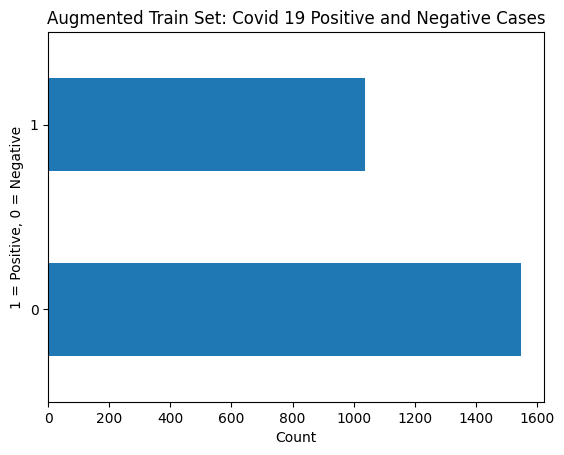

In [12]:
df = pd.read_csv("./augmented_train_data.csv")

# Get the is_positive column as a series
is_positive = df['is_positive']

# Count the number of True and False values
count = is_positive.value_counts()

# Plot the counts as a horizontal bar chart
count.plot(kind='barh')
plt.title('Augmented Train Set: Covid 19 Positive and Negative Cases')
plt.xlabel('Count')
plt.ylabel('1 = Positive, 0 = Negative')
plt.show()


In [13]:
is_positive.value_counts()

0    1546
1    1036
Name: is_positive, dtype: int64

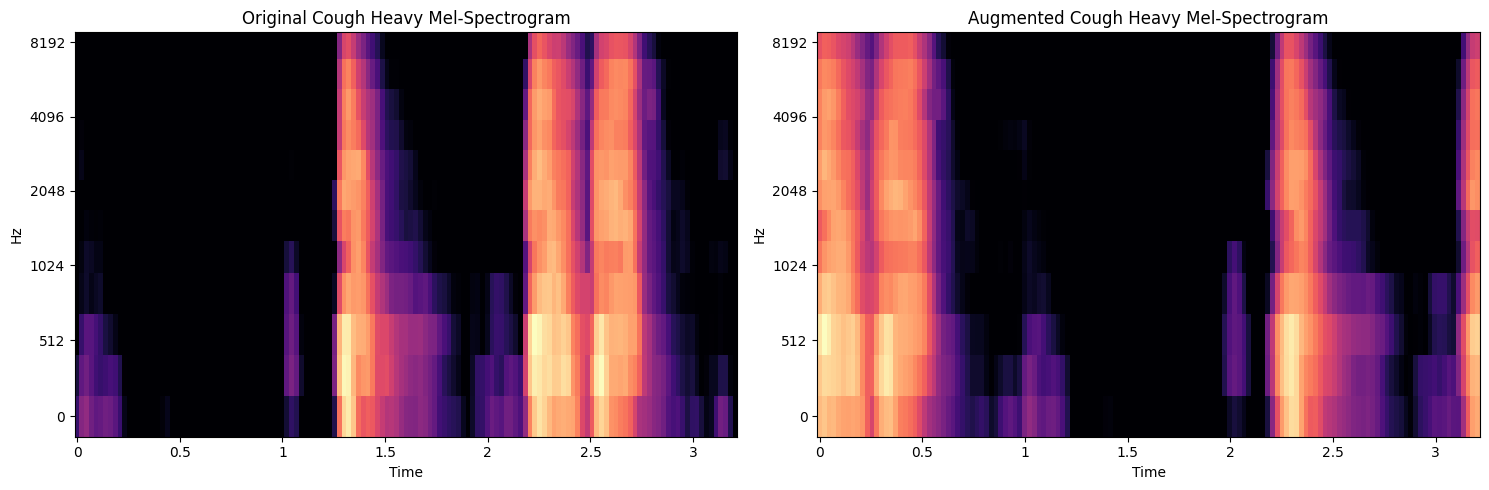

In [14]:
org_filename = './Extracted_data/20210930/rAWA4P9I7iYPCIvEheITe8FCRKP2/cough-heavy.wav'
aug_filename = './Extracted_data/Augmented_Audio/rAWA4P9I7iYPCIvEheITe8FCRKP2/cough-heavy.wav'
y, sr = librosa.load(org_filename,  mono=True)
y, index = librosa.effects.trim(y)
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=12, fmax=8000)

aug_y, aug_sr = librosa.load(aug_filename,  mono=True)
aug_y, index = librosa.effects.trim(aug_y)
aug_mel_spectrogram = librosa.feature.melspectrogram(y=aug_y, sr=aug_sr, n_mels=12, fmax=8000)

fig, ax = plt.subplots(ncols=2, figsize=(15,5))

librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', fmax=8000, x_axis='time', ax=ax[0])
ax[0].set(title='Original Cough Heavy Mel-Spectrogram')
librosa.display.specshow(librosa.power_to_db(aug_mel_spectrogram, ref=np.max), y_axis='mel', fmax=8000, x_axis='time', ax=ax[1])
ax[1].set(title='Augmented Cough Heavy Mel-Spectrogram')


plt.tight_layout()
plt.show()



In [15]:
df = df.replace([np.inf, -np.inf], np.finfo(np.float64).max)
df = df.dropna()

In [16]:
X = df.drop(['is_positive'], axis=1)
y = df['is_positive']
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
print(y_resampled.value_counts())

0    1036
1    1036
Name: is_positive, dtype: int64


In [17]:
df = pd.concat([X_resampled, y_resampled], axis=1)
df.to_csv('understampling_augmented_train_data_with_features_without_normalize_with.csv', index=False)